In [0]:
!pip install -U --pre tensorflow=="1.*"
!pip install pycocotools

import tensorflow as tf;
import os
import pathlib

import pandas as pd
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

print(tf.__version__);


import tensorflow as tf
from google.colab import drive
drive.mount('/content/gdrive')

!ls "/content/gdrive/My Drive/dataset/har"

print("Using Tensorflow version")
print(tf.__version__)

basedir='/content/gdrive/My Drive/dataset/har/'

dataset_path = '/content/gdrive/My Drive/dataset/har/emotiondetection.csv'
image_size=(48,48)
 
def load_emotion_data():
    data = pd.read_csv(dataset_path)
    pixels = data['pixels'].tolist()
    width, height = 48, 48
    faces = []
    for pixel_sequence in pixels:
        face = [int(pixel) for pixel in pixel_sequence.split(' ')]
        face = np.asarray(face).reshape(width, height)
        face = cv2.resize(face.astype('uint8'),image_size)
        faces.append(face.astype('float32'))
    faces = np.asarray(faces)
    faces = np.expand_dims(faces, -1)
    emotions = pd.get_dummies(data['emotion']).as_matrix()
    return faces, emotions
 
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    if v2:
        x = x - 0.5
        x = x * 2.0
    return x
 
faces, emotions = load_emotion_data()
faces = preprocess_input(faces)
xtrain, xtest,ytrain,ytest = train_test_split(faces, emotions,test_size=0.2,shuffle=True)





from  keras.layers import Activation, Convolution2D, Dropout, Conv2D
from  keras.layers import AveragePooling2D, BatchNormalization
from  keras.layers import GlobalAveragePooling2D
from  keras.models import Sequential
from  keras.layers import Flatten
from  keras.models import Model
from  keras.layers import Input
from  keras.layers import MaxPooling2D
from  keras.layers import SeparableConv2D
from  keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from  keras.callbacks import ReduceLROnPlateau
from  keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from  keras import layers
from  keras.regularizers import l2
import pandas as pd
import cv2
import numpy as np
 
# parameters
batch_size = 32
num_epochs = 10
verbose = 1
num_classes = 7
patience = 50
base_path = basedir+'models/'
#print(base_path)
l2_regularization=0.01
 
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
 
# model parameters
input_shape = (48, 48, 1)
regularization = l2(l2_regularization)
img_input = Input(input_shape)

def inputNN(in_img):
  x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(in_img)
  x = Activation('relu')(x)
  x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization, use_bias=False)(x)
  x = Activation('relu')(x)
  return x
 

def multiTensor(x,ksize):
  residual = Conv2D(ksize, (1, 1), strides=(2, 2), padding='same', use_bias=False)(x)
  residual = BatchNormalization()(residual)
  x = SeparableConv2D(ksize, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
  x = Activation('relu')(x)
  x = SeparableConv2D(ksize, (3, 3), padding='same', kernel_regularizer=regularization, use_bias=False)(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
  x = layers.add([x, residual])
  return x


def outputLayer(x):
  x = Conv2D(num_classes, (3, 3), padding='same')(x)
  x = GlobalAveragePooling2D()(x)
  output = Activation('softmax',name='predictions')(x)
  return output


x=inputNN(img_input)
x=multiTensor(x,16)
x=multiTensor(x,32) 
x=multiTensor(x,64)
x=multiTensor(x,128)
output=outputLayer(x) 

model = Model(img_input, output)
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
 
logfile = base_path + '_emotion_training.log'
logger = CSVLogger(logfile, append=False)
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=int(patience/4), verbose=1)
trained_models_path = base_path + '_emotion_train_model'
model_names = trained_models_path + '.{epoch:02d}-{val_acc:.2f}.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint, logger, early_stop, reduce_lr]
 
model.fit_generator(data_generator.flow(xtrain, ytrain,batch_size),
                        steps_per_epoch=len(xtrain) / batch_size,
                        epochs=num_epochs, verbose=1, callbacks=callbacks,
                        validation_data=(xtest,ytest))





Requirement already up-to-date: tensorflow==1.* in /usr/local/lib/python3.6/dist-packages (1.15.0)
1.15.0
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
data  emotiondetection.csv  image  models  output-data	test-data
Using Tensorflow version
1.15.0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 46, 46, 8)    72          input_2[0][0]                    
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 46, 46, 8)    0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 44, 44, 8)    576         activation_7[0][0]               
____________________________________________________________________________________________

/content/gdrive/My Drive/dataset/har/image/boy-1.jpg


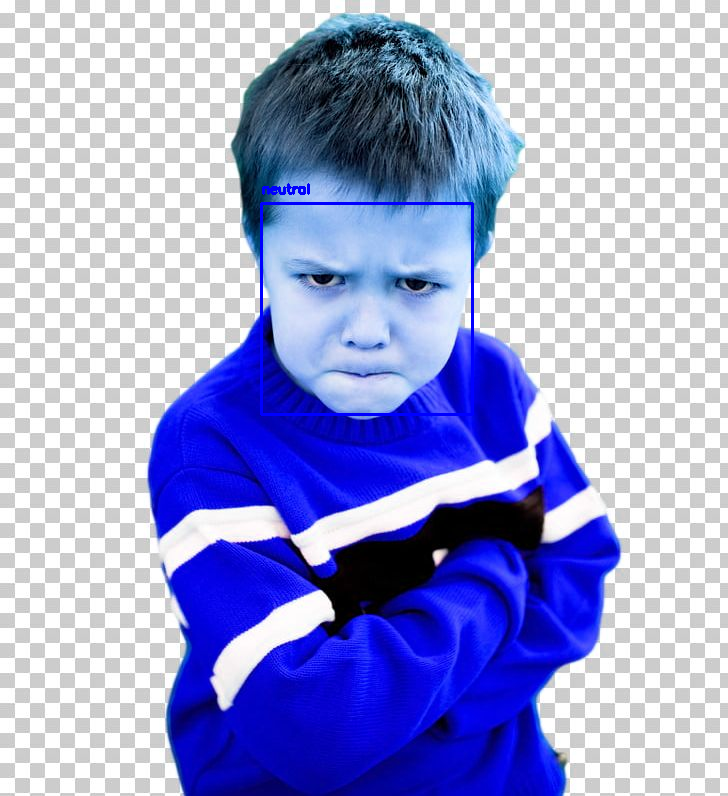

In [0]:
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import imutils
import cv2
import numpy as np
import sys
from google.colab.patches import cv2_imshow
 
# parameters for loading data and images
detection_model_path = basedir+'data/haarcascades/haarcascade_frontalface_default.xml'
emotion_model_path = basedir+'models/_emotion_train_model.10-0.54.hdf5'

img_path = basedir+'image/boy-1.jpg'
print(img_path)
 
# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]
 
#reading the frame
orig_frame = cv2.imread(img_path)
frame = cv2.imread(img_path,0)
faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
 
if len(faces) > 0:
    faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
    (fX, fY, fW, fH) = faces
    roi = frame[fY:fY + fH, fX:fX + fW]
    roi = cv2.resize(roi, (48, 48))
    roi = roi.astype("float") / 255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)
    preds = emotion_classifier.predict(roi)[0]
    emotion_probability = np.max(preds)
    label = EMOTIONS[preds.argmax()]
    cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
    cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)

img_rgb = cv2.cvtColor(orig_frame, cv2.COLOR_BGR2RGB)
cv2_imshow(img_rgb)
cv2.imwrite(basedir+'test_output/'+img_path.split('/')[-1],orig_frame)
if (cv2.waitKey(2000) == ord('q')):
    sys.exit("Thanks")
cv2.destroyAllWindows()

In [0]:
from keras.preprocessing.image import img_to_array
import imutils
import cv2
from keras.models import load_model
from google.colab.patches import cv2_imshow
import numpy as np
# parameters for loading data and images
basedir='/content/gdrive/My Drive/dataset/har/'

detection_model_path = basedir+'data/haarcascades/haarcascade_frontalface_default.xml'
emotion_model_path = basedir+'models/_emotion_train_model.10-0.54.hdf5'

# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ["angry" ,"disgust","scared", "happy", "sad", "surprised",
 "neutral"]


VIDEO_DIR=basedir+'test-data/'
VIDEO_SAVE_DIR=basedir+'test-data/frames/'
VIDEO_OUT_DIR=basedir+'output-data'

frame_count=0
batch_size=1
#frames=[]
capture = cv2.VideoCapture(os.path.join(VIDEO_DIR, '20191116_130301.mp4'))    
while True:
    ret, frame = capture.read()
    if not ret:
        break        
    frame = imutils.resize(frame,width=400)
    # Bail out when the video file ends
    orig_frame = frame
    # Save each frame of the video to a list
    frame_count += 1
    #frame = imutils.resize(frame,width=400)

    #frame = cv2.imread(img_path,0)
    faces = face_detection.detectMultiScale(frame,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
    print(faces);
    if len(faces) > 0:
      faces = sorted(faces, reverse=True,
      key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0] 
      (fX, fY, fW, fH) = faces
                      # Extract the ROI of the face from the grayscale image, resize it to a fixed 48x48 pixels, and then prepare
              # the ROI for classification via the CNN
      roi = gray[fY:fY + fH, fX:fX + fW]
      roi = cv2.resize(roi, (48, 48))
      roi = roi.astype("float") / 255.0
      roi = img_to_array(roi)
      roi = np.expand_dims(roi, axis=0)
      preds = emotion_classifier.predict(roi)[0]
      emotion_probability = np.max(preds)
      label = EMOTIONS[preds.argmax()]
      cv2.putText(orig_frame, label, (fX, fY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
      cv2.rectangle(orig_frame, (fX, fY), (fX + fW, fY + fH),(0, 0, 255), 2)
      print(VIDEO_SAVE_DIR);

    img_rgb = cv2.cvtColor(orig_frame, cv2.COLOR_BGR2RGB)
    cv2_imshow(img_rgb)
    name = VIDEO_SAVE_DIR+'{0}.jpg'.format(frame_count)
    print(name)
    cv2.imwrite(name, img_rgb)
 


In [0]:
import glob

# Get all image file paths to a list.
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by name index.
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))


video = cv2.VideoCapture(os.path.join(VIDEO_DIR, '20191116_130301.mp4'));

# Find OpenCV version
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

if int(major_ver)  < 3 :
    fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(fps))
else :
    fps = video.get(cv2.CAP_PROP_FPS)
    print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(fps))

video.release();




def generate_video(outvid, images=None, fps=30, size=None,
               is_color=True, format="FMP4"):
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

import glob
import os

# Directory of images to run detection on
VIDEO_DIR = os.path.join(VIDEO_OUT_DIR, "videos")
images = list(glob.iglob(os.path.join(VIDEO_SAVE_DIR, '*.*')))
# Sort the images by integer index
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))

outvid = os.path.join(VIDEO_DIR, "out.mp4")
generate_video(outvid, images, fps=30)